In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q "/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/train.zip" -d "/content/data"


In [3]:
import yaml
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
# Загрузка настроек
with open('/content/drive/MyDrive/Dissertation/Desertation_train_3model/дисертация_за_месяц/parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Установка сидов
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


# Загружаем модель и параметры
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")
num_epochs = config['training']['num_epochs']
batch_size = config['training']['batch_size']
early_stopping_patience = config['training']['patience']
learning_rate = config['training'].get('learning_rate', 1e-4)
weight_decay = config['training'].get('weight_decay', 0.0)


root_dir = '/content/data/train'

In [6]:
# Путь к данным
train_csv = config['dataset']['train_csv']
df = pd.read_csv(train_csv)

In [7]:
df['true_label'] = df['true_label'].astype(int)
print("Распределение классов:")
print(df['true_label'].value_counts())

Распределение классов:
true_label
0    20648
1     6886
2      566
Name: count, dtype: int64


In [8]:
from torchvision import transforms

def get_transform_pipeline(config, label=None):
    transform_list = []

    # Только resize — как базовая подготовка изображения
    transform_list.append(transforms.Resize(config['dataset']['image_size']))

    # Преобразование в тензор и нормализация
    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])
    ])

    return transforms.Compose(transform_list)


In [9]:
# Feature Extractor для ViT
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name'] + '.jpg'
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")

        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name


In [10]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def train_model(model, train_loader, val_loader, optimizer, device, config):
    import torch.backends.cudnn
    torch.backends.cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    early_stopping_patience = config['training'].get('early_stopping_patience', 3)
    model_save_path = config['training'].get('model_save_path', 'best_model.pth')
    num_epochs = config['training'].get('num_epochs', 20)

    # Активация компиляции (PyTorch ≥ 2.0)
    if hasattr(torch, 'compile'):
        model = torch.compile(model)

    # Mixed Precision
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels, _ in train_loader:
            inputs = inputs.to(device, memory_format=torch.channels_last)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device, memory_format=torch.channels_last)
                labels = labels.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    loss = criterion(logits, labels)

                running_val_loss += loss.item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
        elif epoch > 0 and avg_val_loss > best_val_loss and avg_train_loss < train_losses[-2]:
            patience_counter += 1
            print(f"Validation loss ↑ while train loss ↓. Patience {patience_counter}/{early_stopping_patience}")
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered due to overfitting.")
                break

    # Final metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("\n Final Metrics on Validation Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    plot_training_history(train_losses, val_losses)



====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-35ff8e3b5ec9>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-35ff8e3b5ec9>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-11-35ff8e3b5ec9>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader wi

Epoch 1/50 | Train Loss: 0.9088 | Val Loss: 0.7704


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-35ff8e3b5ec9>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/50 | Train Loss: 0.7187 | Val Loss: 0.6829
Epoch 3/50 | Train Loss: 0.6678 | Val Loss: 0.6544
Epoch 4/50 | Train Loss: 0.6444 | Val Loss: 0.6351
Epoch 5/50 | Train Loss: 0.6218 | Val Loss: 0.6111
Epoch 6/50 | Train Loss: 0.5967 | Val Loss: 0.5887
Epoch 7/50 | Train Loss: 0.5763 | Val Loss: 0.5747
Epoch 8/50 | Train Loss: 0.5617 | Val Loss: 0.5643
Epoch 9/50 | Train Loss: 0.5494 | Val Loss: 0.5548
Epoch 10/50 | Train Loss: 0.5379 | Val Loss: 0.5473
Epoch 11/50 | Train Loss: 0.5280 | Val Loss: 0.5416
Epoch 12/50 | Train Loss: 0.5191 | Val Loss: 0.5363
Epoch 13/50 | Train Loss: 0.5096 | Val Loss: 0.5324
Epoch 14/50 | Train Loss: 0.5015 | Val Loss: 0.5289
Epoch 15/50 | Train Loss: 0.4943 | Val Loss: 0.5261
Epoch 16/50 | Train Loss: 0.4861 | Val Loss: 0.5225
Epoch 17/50 | Train Loss: 0.4773 | Val Loss: 0.5231
Validation loss ↑ while train loss ↓. Patience 1/3
Epoch 18/50 | Train Loss: 0.4693 | Val Loss: 0.5196
Epoch 19/50 | Train Loss: 0.4626 | Val Loss: 0.5188
Epoch 20/50 | Train L

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


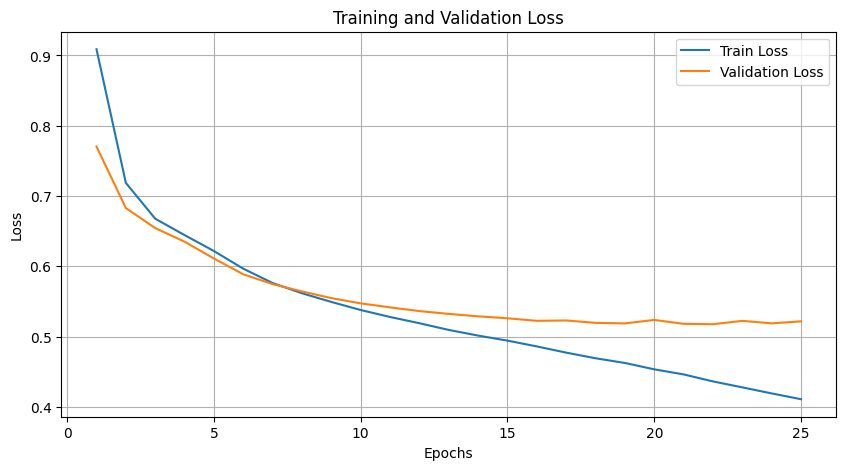


 Все фолды завершены. 

====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-35ff8e3b5ec9>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-35ff8e3b5ec9>:30: 

Epoch 1/50 | Train Loss: 0.8422 | Val Loss: 0.7388
Epoch 2/50 | Train Loss: 0.6936 | Val Loss: 0.6657
Epoch 3/50 | Train Loss: 0.6478 | Val Loss: 0.6344
Epoch 4/50 | Train Loss: 0.6200 | Val Loss: 0.6095
Epoch 5/50 | Train Loss: 0.5971 | Val Loss: 0.5899
Epoch 6/50 | Train Loss: 0.5787 | Val Loss: 0.5757
Epoch 7/50 | Train Loss: 0.5636 | Val Loss: 0.5646
Epoch 8/50 | Train Loss: 0.5507 | Val Loss: 0.5554
Epoch 9/50 | Train Loss: 0.5392 | Val Loss: 0.5496
Epoch 10/50 | Train Loss: 0.5299 | Val Loss: 0.5415
Epoch 11/50 | Train Loss: 0.5208 | Val Loss: 0.5360
Epoch 12/50 | Train Loss: 0.5115 | Val Loss: 0.5316
Epoch 13/50 | Train Loss: 0.5040 | Val Loss: 0.5280
Epoch 14/50 | Train Loss: 0.4955 | Val Loss: 0.5255
Epoch 15/50 | Train Loss: 0.4877 | Val Loss: 0.5218
Epoch 16/50 | Train Loss: 0.4804 | Val Loss: 0.5183
Epoch 17/50 | Train Loss: 0.4726 | Val Loss: 0.5168
Epoch 18/50 | Train Loss: 0.4659 | Val Loss: 0.5196
Validation loss ↑ while train loss ↓. Patience 1/3
Epoch 19/50 | Train Lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


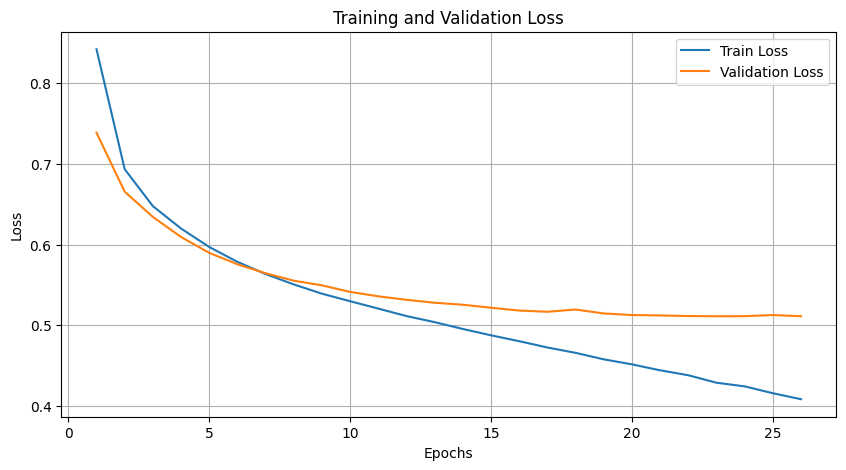


 Все фолды завершены. 

====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-35ff8e3b5ec9>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-11-35ff8e3b5ec9>:30: 

Epoch 1/50 | Train Loss: 0.9647 | Val Loss: 0.7818
Epoch 2/50 | Train Loss: 0.7272 | Val Loss: 0.6952
Epoch 3/50 | Train Loss: 0.6768 | Val Loss: 0.6652
Epoch 4/50 | Train Loss: 0.6528 | Val Loss: 0.6468
Epoch 5/50 | Train Loss: 0.6354 | Val Loss: 0.6286
Epoch 6/50 | Train Loss: 0.6153 | Val Loss: 0.6082
Epoch 7/50 | Train Loss: 0.5940 | Val Loss: 0.5881
Epoch 8/50 | Train Loss: 0.5753 | Val Loss: 0.5729
Epoch 9/50 | Train Loss: 0.5606 | Val Loss: 0.5633
Epoch 10/50 | Train Loss: 0.5495 | Val Loss: 0.5535
Epoch 11/50 | Train Loss: 0.5387 | Val Loss: 0.5502
Epoch 12/50 | Train Loss: 0.5295 | Val Loss: 0.5405
Epoch 13/50 | Train Loss: 0.5215 | Val Loss: 0.5355
Epoch 14/50 | Train Loss: 0.5137 | Val Loss: 0.5309
Epoch 15/50 | Train Loss: 0.5061 | Val Loss: 0.5278
Epoch 16/50 | Train Loss: 0.4987 | Val Loss: 0.5240
Epoch 17/50 | Train Loss: 0.4920 | Val Loss: 0.5220
Epoch 18/50 | Train Loss: 0.4853 | Val Loss: 0.5195
Epoch 19/50 | Train Loss: 0.4788 | Val Loss: 0.5174
Epoch 20/50 | Train L

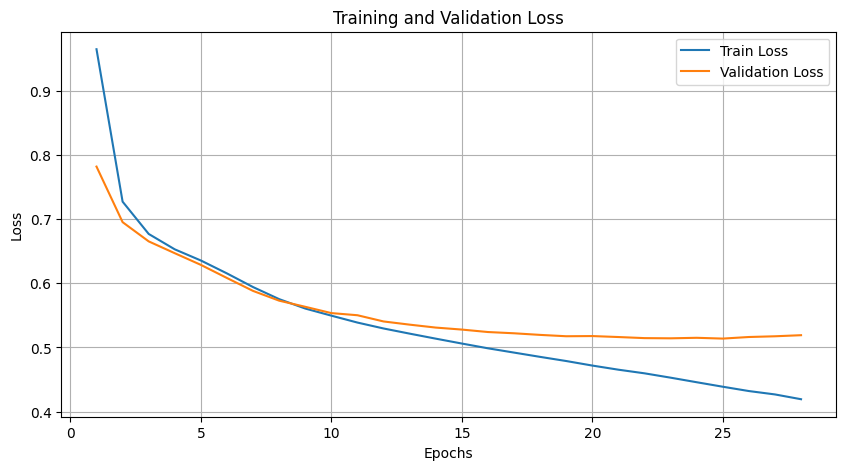


 Все фолды завершены. 


In [12]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import os

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
all_results = []
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['true_label'])):
    print(f"\n====== Fold {fold + 1} ======")
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

     # --- Создание датасетов и загрузчиков ---
    train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
    val_dataset = FundusDataset(val_df, root_dir=root_dir, config=config)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=22, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=22, pin_memory=True)

    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k", num_labels=3, ignore_mismatched_sizes=True
    )
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    config['training']['model_save_path'] = f"best_model_fold{fold + 1}.pth"

    train_model(model, train_loader, val_loader, optimizer, device, config)
    print("\n Все фолды завершены. ")
